# Download the model

In [2]:
# Example inspired from https://huggingface.co/microsoft/Phi-3-vision-128k-instruct

# Import necessary libraries
from PIL import Image
import requests
from transformers import AutoModelForCausalLM
from transformers import AutoProcessor
from transformers import BitsAndBytesConfig
import torch
from IPython.display import display
import time


# Define model ID
model_id = "microsoft/Phi-3-vision-128k-instruct"

# Load processor
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

# Define BitsAndBytes configuration for 4-bit quantization
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# Load model with 4-bit quantization and map to CUDA
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda",
    trust_remote_code=True,
    torch_dtype="auto",
    quantization_config=nf4_config,
)

/home/randellini/anaconda3/envs/llm_images/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/randellini/anaconda3/envs/llm_images/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/randellini/anaconda3/envs/llm_images/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
def model_inference(messages, path_image):
    
    start_time = time.time()
    
    image = Image.open(path_image)

    # Prepare prompt with image token
    prompt = processor.tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    # Process prompt and image for model input
    inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0")

    # Generate text response using model
    generate_ids = model.generate(
        **inputs,
        eos_token_id=processor.tokenizer.eos_token_id,
        max_new_tokens=500,
        do_sample=False,
    )

    # Remove input tokens from generated response
    generate_ids = generate_ids[:, inputs["input_ids"].shape[1] :]

    # Decode generated IDs to text
    response = processor.batch_decode(
        generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]


    display(image)
    end_time = time.time()
    print("Inference time: {}".format(end_time - start_time))

    # Print the generated response
    print(response)

# Identity card - OCR

## Front

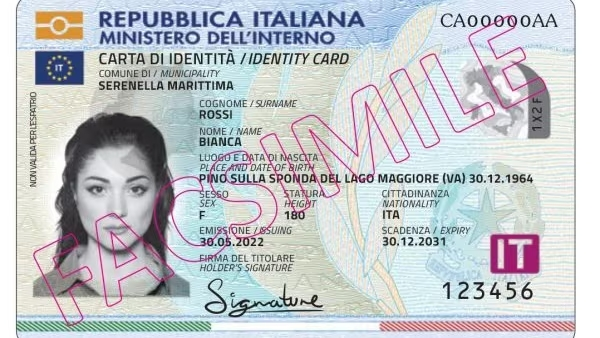

Inference time: 9.793543815612793
{
"Comune Di/ Municipality": "SERENELLA MARITTIMA",
"COGNOME /Surname": "ROSSI",
"NOME/NAME": "BIANCA",
"LUOGO E DATA DI NASCITA": "PINO SULLA SPONDA DEL LAGO MAGGIORE (VA) 30.12.1964",
"SESSO/SEX": "F",
"STATURA/HEIGHT": "180",
"CITADINANZA/NATIONALITY": "ITA",
"EMISSIONE/ ISSUING": "30.05.2022",
"SCADENZA /EXPIRY": "30.12.2031",
"CODE": "CAO000AA"
}


In [11]:
prompt_cie_front = [{"role": "user", "content": "<|image_1|>\nOCR the text of the image. Extract the text of the following fields and put it in a JSON format: \
'Comune Di/ Municipality', 'COGNOME /Surname', 'NOME/NAME', 'LUOGO E DATA DI NASCITA/\
PLACE AND DATE OF BIRTH', 'SESSO/SEX', 'STATURA/HEIGHT', 'CITADINANZA/NATIONALITY',\
'EMISSIONE/ ISSUING', 'SCADENZA /EXPIRY'. Read the code at the top right and put in in the JSON field 'CODE'"}]

# Download image from URL
path_image = "/home/randellini/llm_images/resources/cie_fronte.jpg"

# inference
model_inference(prompt_cie_front, path_image)

## Back

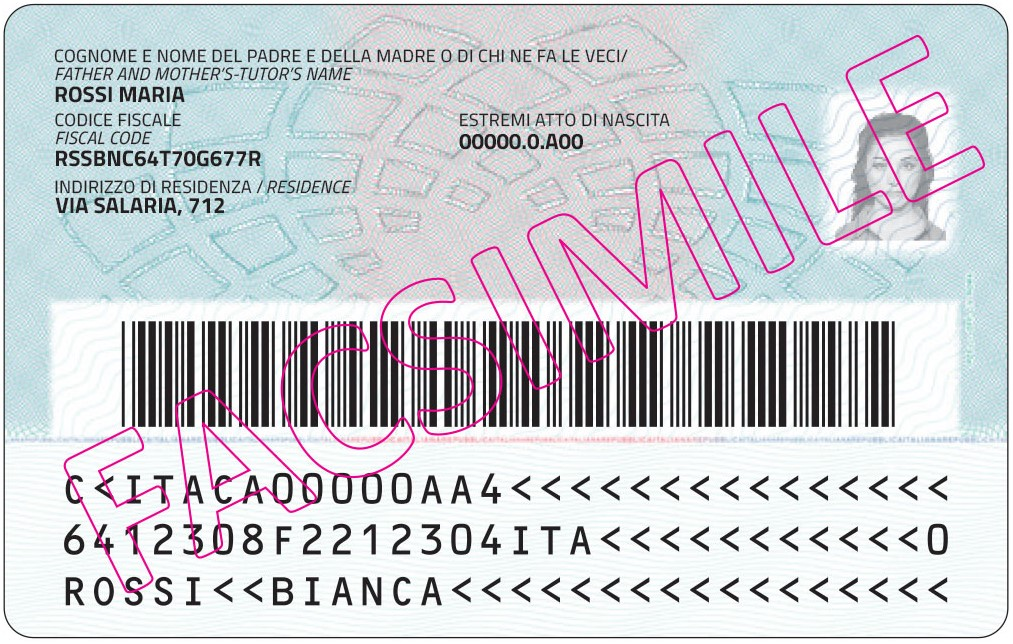

Inference time: 4.082342147827148
{
  "codice_fiscale": "RSBNC64T70G677R",
  "estremi_atto_di_nascita": "00000.0A00",
  "indirizzo_di_residenza": "Via Salaria, 712"
}


In [12]:
prompt_cie_back = [{"role": "user", "content": "<|image_1|>\nOCR the text of the image. Extract the text of the following fields and put it in a JSON format: \
'CODICE FISCALE/FISCAL CODE', 'ESTREMI ATTO DI NASCITA', 'INDIRIZZO DI RESIDENZA/RESIDENCE'"}]

# Download image from URL
path_image = "/home/randellini/llm_images/resources/cie_retro.jpg"

# inference
model_inference(prompt_cie_back, path_image)

# Licence drive - OCR

## Front

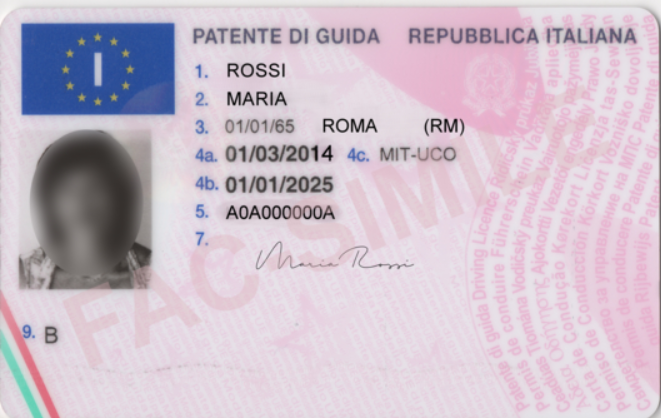

Inference time: 5.2030909061431885
{
"1": "ROSSI",
"2": "MARIA",
"3": "01/01/65",
"4a": "01/03/2014",
"4b": "01/01/2025",
"4c": "MIT-UCO",
"5": "A0A000000A",
"9": "B"
}


In [13]:
prompt_ld_front = [{"role": "user", "content": "<|image_1|>\nOCR the text of the image. Extract the text of the following fields and put it in a JSON format: \
'1.', '2.', '3.', '4a.', '4b.', '4c.', '5.','9.'"}]

# Download image from URL
path_image = "/home/randellini/llm_images/resources/patente_fronte.png"

# inference
model_inference(prompt_ld_front, path_image)

# Health insurance card - OCR

## Front

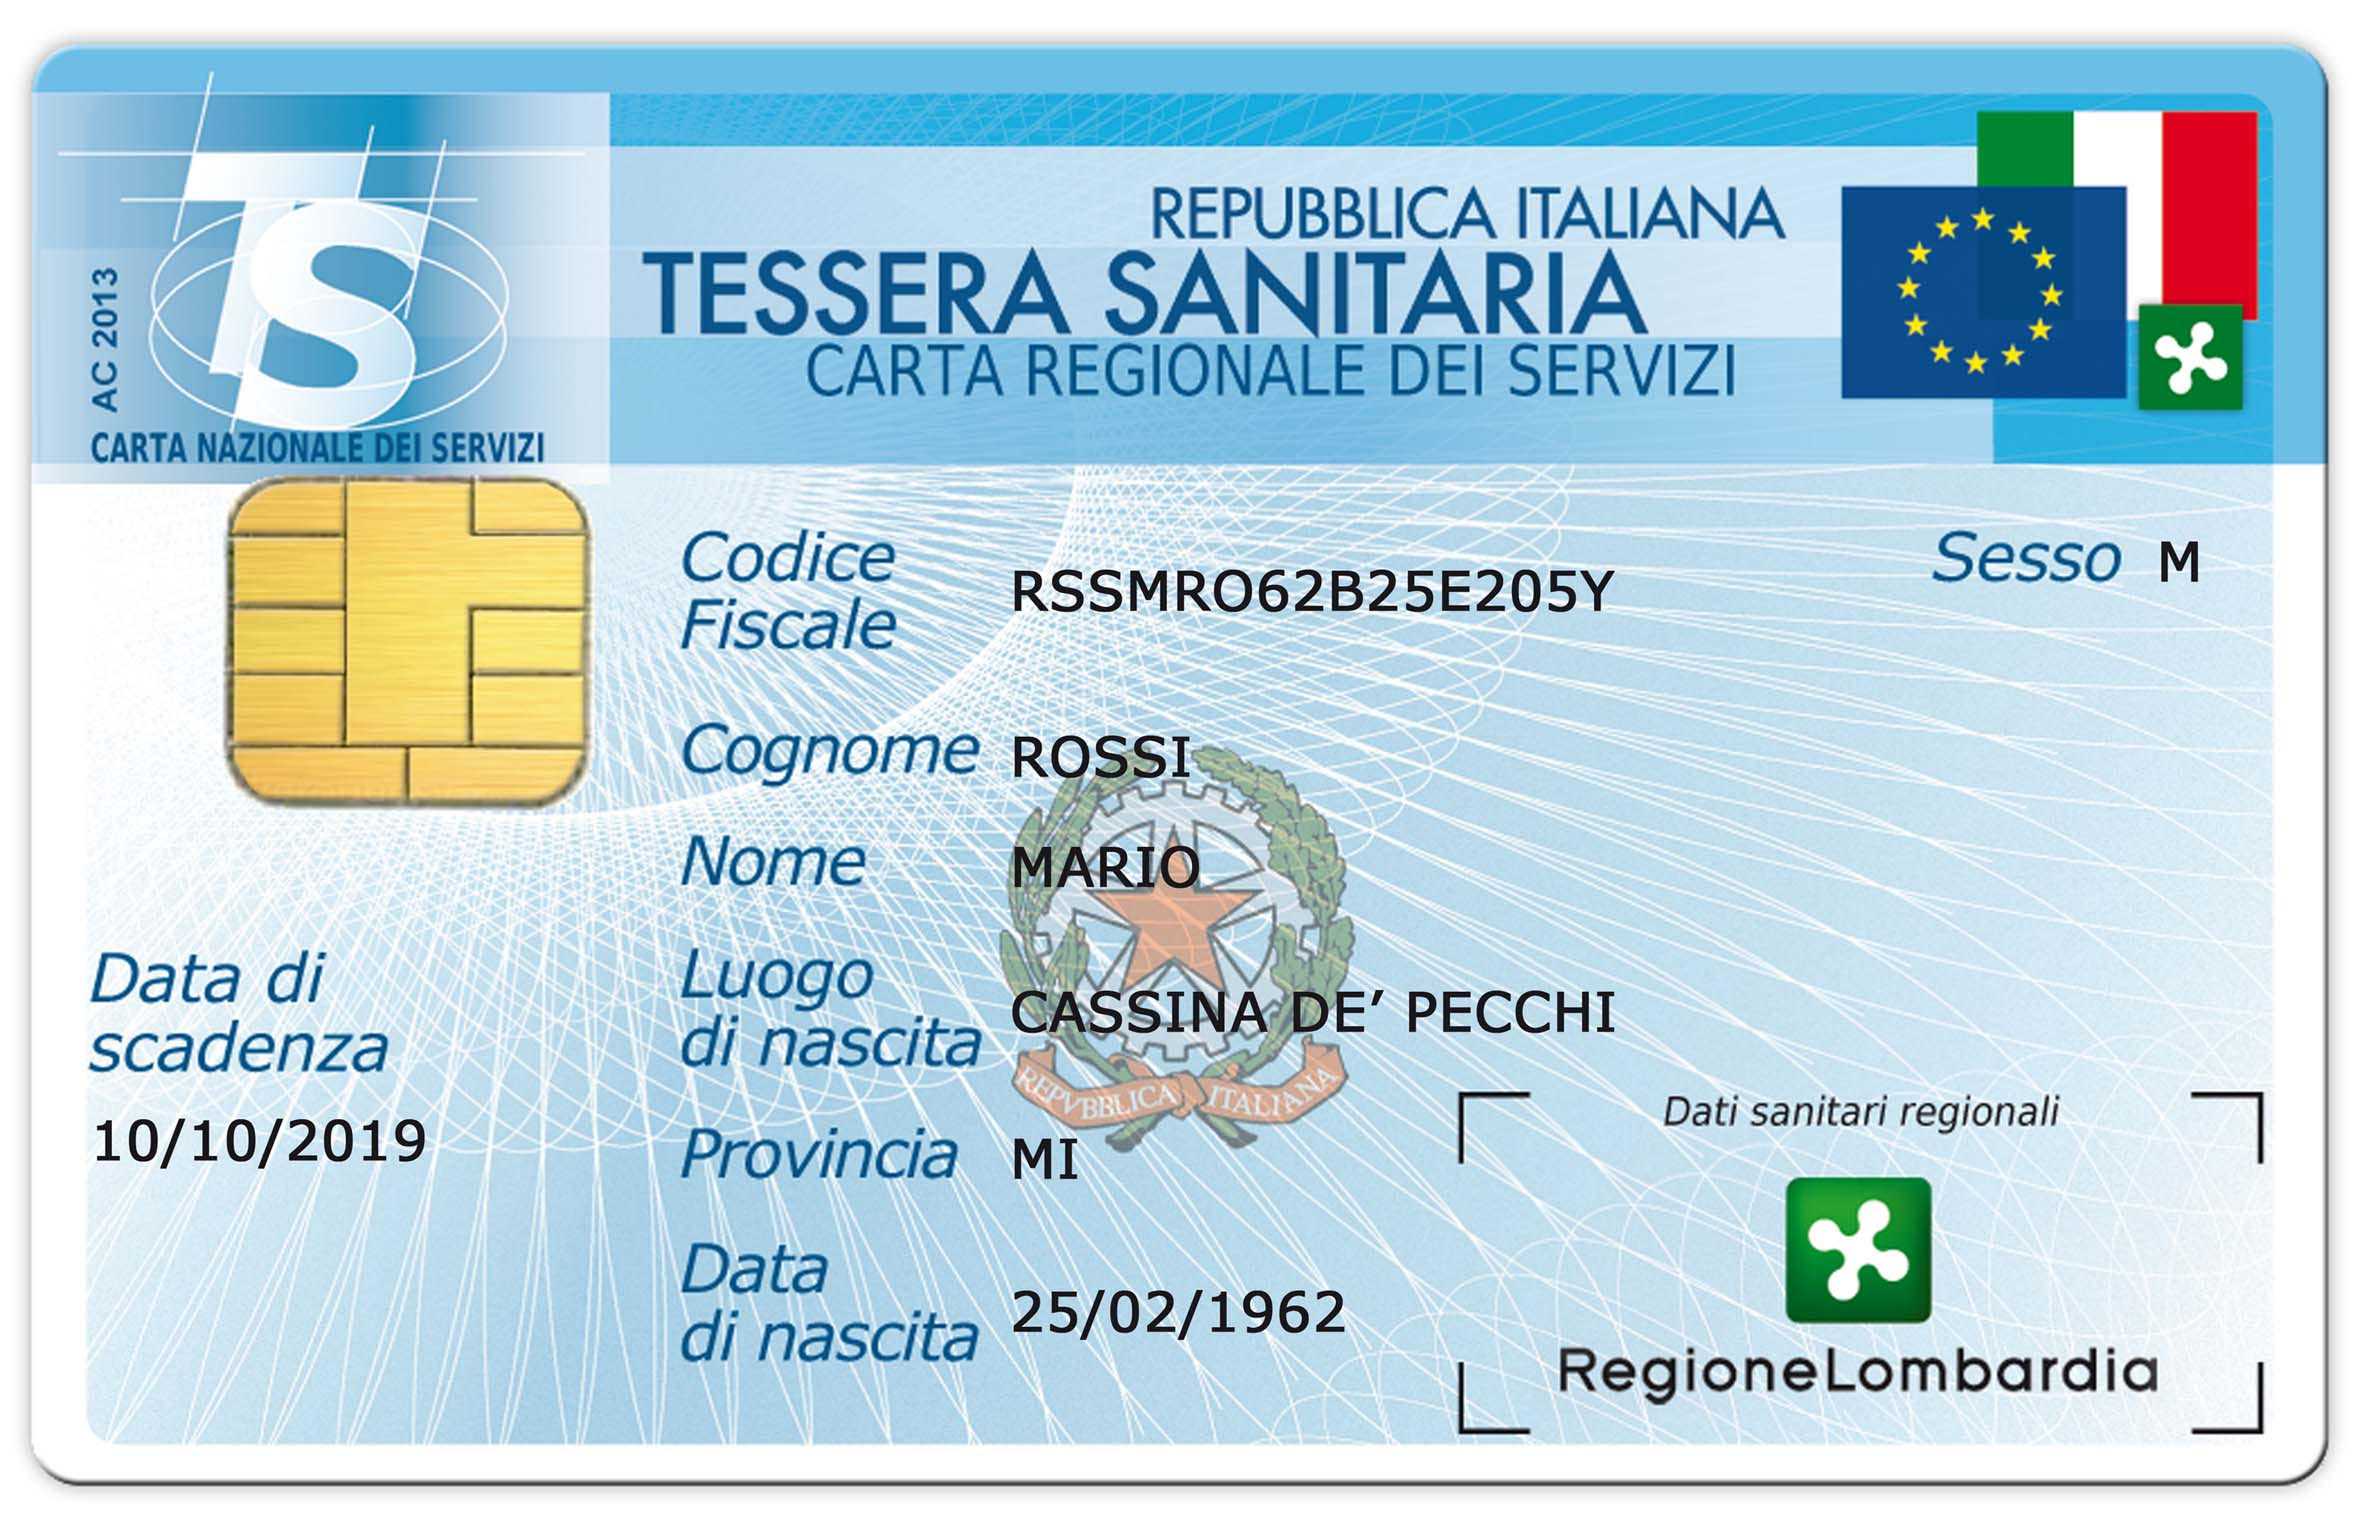

Inference time: 7.003508806228638
```json
{
  "Codice Fiscale": "RSSMRO62B25E205Y",
  "Sesso": "M",
  "Cognome": "ROSSI",
  "Nome": "MARIO",
  "Luogo di nascita": "CASSINA DE' PECCHI",
  "Provincia": "MI",
  "Data di nascita": "25/02/1962",
  "Data di scadenza": "10/10/2019"
}
```


In [14]:
prompt_hic_front = [{"role": "user", "content": "<|image_1|>\nOCR the text of the image. Extract the text of the following fields and put it in a JSON format: \
'Codice Fiscale', 'Sesso', 'Cognome', 'Nome', 'Luogo di nascita', 'Provincia', 'Data di nascita', 'Data di scadenza'"}]

# Download image from URL
path_image = "/home/randellini/llm_images/resources/tessera_sanitaria_fronte.jpg"

# inference
model_inference(prompt_hic_front, path_image)

## Back

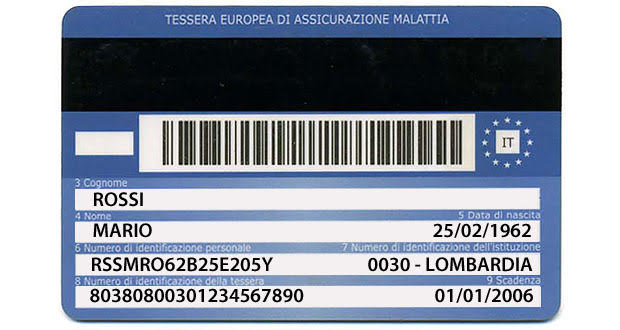

Inference time: 7.403932809829712
{
"3 Cognome": "ROSSI",
"4 Nome": "MARIO",
"5 Data di nascita": "25/02/1962",
"6 Numero identificativo personale": "RSSMRO62B25E205Y",
"7 Numero identificazione dell'istituzione": "0030 - LOMBARDIA",
"Numero di identificazione della tessera": "80380800301234567890",
"9 Scadenza": "01/01/2006"
}


In [15]:
prompt_hic_back = [{"role": "user", "content": "<|image_1|>\nOCR the text of the image. Extract the text of the following fields and put it in a JSON format: \
'3 Cognome', '4 Nome', '5 Data di nascita', '6 Numero identificativo personale', '7 Numero identificazione dell'istituzione', 'Numero di identificazione della tessera', '9 Scadenza'"}]

# Download image from URL
path_image = "/home/randellini/llm_images/resources/tessera_sanitaria_retro.jpg"

# inference
model_inference(prompt_hic_back, path_image)